In [1]:
"""
CNNT-like Keras model (patched) with convolutional Q-K multi-head attention as a Layer.
Save as e.g. cnnt_model.py
"""

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation,
    MaxPooling2D, Add, Concatenate, Reshape, LayerNormalization,
    Dense, Dropout, Layer
)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K


# -------------------------
# InstanceNormalization
# -------------------------
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, affine=False, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.affine = affine

    def build(self, input_shape):
        if self.affine:
            self.gamma = self.add_weight(
                shape=(input_shape[-1],), initializer="ones", trainable=True, name="gamma"
            )
            self.beta = self.add_weight(
                shape=(input_shape[-1],), initializer="zeros", trainable=True, name="beta"
            )
        super().build(input_shape)

    def call(self, x):
        mean, var = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        x = (x - mean) / tf.sqrt(var + self.epsilon)
        if self.affine:
            x = x * self.gamma + self.beta
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"epsilon": self.epsilon, "affine": self.affine})
        return config


# -------------------------
# MultiHeadConvQKAttention Layer
# -------------------------
class MultiHeadConvQKAttention(Layer):
    """
    Local convolutional multi-head attention layer.
    For each spatial position p, computes dot(Q_p, K_j) over a local kxk window,
    softmax across the window, and aggregates V_j with those weights.
    """

    def __init__(self, heads=4, kernel_size=3, ff_dim=None, proj_if_not_divisible=True, **kwargs):
        super().__init__(**kwargs)
        if kernel_size % 2 == 0:
            raise ValueError("kernel_size must be odd.")
        self.heads = int(heads)
        self.kernel_size = int(kernel_size)
        self.ff_dim = ff_dim
        self.proj_if_not_divisible = bool(proj_if_not_divisible)

        # placeholders for sublayers (created in build)
        self.q_proj = None
        self.k_proj = None
        self.v_proj = None
        self.res_proj = None
        self.fuse_conv = None
        self.fuse_bn = None
        self.fuse_act = None
        self.attn_ln = None
        self.ff1 = None
        self.ff2 = None
        self.ff_ln = None

    def build(self, input_shape):
        # input_shape: (batch, H, W, C)
        if input_shape[-1] is None:
            raise ValueError("MultiHeadConvQKAttention requires a statically known channel dimension at build time.")
        self.C = int(input_shape[-1])

        # compute output channels (project if needed)
        if self.proj_if_not_divisible and (self.C % self.heads != 0):
            new_C = ((self.C + self.heads - 1) // self.heads) * self.heads
        else:
            new_C = self.C

        self.out_channels = new_C
        self.depth = self.out_channels // self.heads

        # create 1x1 convs for Q, K, V
        name_base = None if self.name is None else self.name
        self.q_proj = Conv2D(self.out_channels, kernel_size=1, padding="same", use_bias=False,
                             name=(None if name_base is None else f"{name_base}_q_proj"))
        self.k_proj = Conv2D(self.out_channels, kernel_size=1, padding="same", use_bias=False,
                             name=(None if name_base is None else f"{name_base}_k_proj"))
        self.v_proj = Conv2D(self.out_channels, kernel_size=1, padding="same", use_bias=False,
                             name=(None if name_base is None else f"{name_base}_v_proj"))

        # residual projection if input channels != out_channels
        if self.C != self.out_channels:
            self.res_proj = Conv2D(self.out_channels, kernel_size=1, padding="same", use_bias=False,
                                   name=(None if name_base is None else f"{name_base}_res_proj"))
        else:
            self.res_proj = None

        # fuse conv/bn/act after attention block
        self.fuse_conv = Conv2D(self.out_channels, kernel_size=1, padding="same", use_bias=False,
                                name=(None if name_base is None else f"{name_base}_fuse"))
        self.fuse_bn = BatchNormalization(name=(None if name_base is None else f"{name_base}_fuse_bn"))
        self.fuse_act = Activation("relu", name=(None if name_base is None else f"{name_base}_fuse_act"))

        # attention LN and token-wise FFN layers
        self.attn_ln = LayerNormalization(name=(None if name_base is None else f"{name_base}_attn_ln"))

        ff_dim_val = self.ff_dim if self.ff_dim is not None else max(64, self.out_channels * 2)
        self.ff1 = Dense(ff_dim_val, activation="relu", name=(None if name_base is None else f"{name_base}_ff1"))
        self.ff2 = Dense(self.out_channels, name=(None if name_base is None else f"{name_base}_ff2"))
        self.ff_ln = LayerNormalization(name=(None if name_base is None else f"{name_base}_ff_ln"))

        super().build(input_shape)

    def call(self, x):
        # x: (B, H, W, C_in)
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        bs = tf.shape(x)[0]
        H = tf.shape(x)[1]
        W = tf.shape(x)[2]
        C = self.out_channels
        ks = self.kernel_size
        kernel_area = ks * ks

        # reshape q -> (B, H, W, heads, depth)
        q = tf.reshape(q, [bs, H, W, self.heads, self.depth])

        # extract patches for k and v: (B, H, W, ka*C)
        patches_k = tf.image.extract_patches(images=k,
                                             sizes=[1, ks, ks, 1],
                                             strides=[1, 1, 1, 1],
                                             rates=[1, 1, 1, 1],
                                             padding='SAME')
        patches_v = tf.image.extract_patches(images=v,
                                             sizes=[1, ks, ks, 1],
                                             strides=[1, 1, 1, 1],
                                             rates=[1, 1, 1, 1],
                                             padding='SAME')

        # reshape patches -> (B, H, W, ka, C) -> (B, H, W, ka, heads, depth)
        patches_k = tf.reshape(patches_k, [bs, H, W, kernel_area, C])
        patches_v = tf.reshape(patches_v, [bs, H, W, kernel_area, C])
        patches_k = tf.reshape(patches_k, [bs, H, W, kernel_area, self.heads, self.depth])
        patches_v = tf.reshape(patches_v, [bs, H, W, kernel_area, self.heads, self.depth])

        # dot product between q(center) and each k in the window
        q_exp = tf.expand_dims(q, axis=3)  # (B, H, W, 1, heads, depth)
        sim = tf.reduce_sum(q_exp * patches_k, axis=-1)  # (B, H, W, ka, heads)

        # scale and softmax across kernel positions
        sim = sim / tf.math.sqrt(tf.cast(self.depth, tf.float32))
        attn_weights = tf.nn.softmax(sim, axis=3)  # (B, H, W, ka, heads)

        # weighted sum of v patches
        attn_weights_exp = tf.expand_dims(attn_weights, axis=-1)  # (B,H,W,ka,heads,1)
        weighted_v = attn_weights_exp * patches_v  # (B,H,W,ka,heads,depth)
        out_heads = tf.reduce_sum(weighted_v, axis=3)  # (B,H,W,heads,depth)

        # collapse heads -> (B, H, W, C)
        out = tf.reshape(out_heads, [bs, H, W, C])

        # residual (project if needed)
        res = x
        if self.res_proj is not None:
            res = self.res_proj(res)

        out = Add(name=(None if self.name is None else f"{self.name}_attn_res"))([res, out])
        out = self.attn_ln(out)

        # token-wise FFN (B, seq_len, C)
        seq_len = H * W
        tokens = tf.reshape(out, [bs, seq_len, C])

        ff = self.ff1(tokens)
        ff = self.ff2(ff)
        ff = Add(name=(None if self.name is None else f"{self.name}_ff_res"))([tokens, ff])
        ff = self.ff_ln(ff)

        # back to spatial
        out = tf.reshape(ff, [bs, H, W, C])

        out = self.fuse_conv(out)
        out = self.fuse_bn(out)
        out = self.fuse_act(out)
        return out

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "heads": self.heads,
            "kernel_size": self.kernel_size,
            "ff_dim": self.ff_dim,
            "proj_if_not_divisible": self.proj_if_not_divisible
        })
        return cfg


# -------------------------
# cnnt_cell (uses the above attention layer)
# -------------------------
def cnnt_cell(x_in, heads=4, ff_dim=None, mixer_filters=None, dropout_rate=0.1, name=None):
    a = x_in
    x = InstanceNormalization(name=(None if name is None else f"{name}_in1"))(x_in)
    x = Add(name=(None if name is None else f"{name}_add_a"))([x, a])

    # use the layer class inline
    attn_layer = MultiHeadConvQKAttention(heads=heads, kernel_size=3, ff_dim=ff_dim,
                                          proj_if_not_divisible=True,
                                          name=(None if name is None else f"{name}_attn"))
    attn_out = attn_layer(x)
    b = attn_out

    x = InstanceNormalization(name=(None if name is None else f"{name}_in2"))(attn_out)

    # Mixer: force mixer_filters to equal current channels by default
    current_ch = K.int_shape(x)[-1]
    if mixer_filters is None:
        mixer_filters = current_ch

    x = Conv2D(mixer_filters, 3, padding="same", use_bias=False,
               name=(None if name is None else f"{name}_mix_conv1"))(x)
    x = Activation('gelu', name=(None if name is None else f"{name}_gelu"))(x)
    x = Conv2D(mixer_filters, 3, padding="same", use_bias=False,
               name=(None if name is None else f"{name}_mix_conv2"))(x)
    x = Dropout(dropout_rate, name=(None if name is None else f"{name}_drop"))(x)

    b_channels = K.int_shape(b)[-1]
    if b_channels != mixer_filters:
        raise ValueError(f"Channel mismatch inside cnnt_cell('{name}'): b has {b_channels} channels, mixer expected {mixer_filters}. "
                         "Adjust upstream channels/heads or set mixer_filters accordingly.")
    x = Add(name=(None if name is None else f"{name}_add_b"))([x, b])
    return x


# -------------------------
# down_block / up_block / builder
# -------------------------
def down_block(x, cells_per_block=3, heads=4, ff_dim=None, mixer_filters=None, dropout_rate=0.1, name=None):
    x_in = x
    for i in range(cells_per_block):
        x_in = cnnt_cell(x_in, heads=heads, ff_dim=ff_dim, mixer_filters=mixer_filters,
                         dropout_rate=dropout_rate, name=(None if name is None else f"{name}_cell{i}"))
    skip_for_decoder = x_in
    x_down = MaxPooling2D(pool_size=2, name=(None if name is None else f"{name}_pool"))(x_in)
    return x_down, skip_for_decoder


def up_block(x, skip_to_concat, cells_per_block=4, heads=4, ff_dim=None, mixer_filters=None, dropout_rate=0.1, name=None):
    target_ch = K.int_shape(skip_to_concat)[-1]
    x = Conv2DTranspose(target_ch, kernel_size=2, strides=2, padding="same",
                        name=(None if name is None else f"{name}_deconv"))(x)
    x = BatchNormalization(name=(None if name is None else f"{name}_debn"))(x)
    x = Activation("relu", name=(None if name is None else f"{name}_deact"))(x)

    x = Concatenate(axis=-1, name=(None if name is None else f"{name}_concat"))([x, skip_to_concat])

    # Fuse back to target_ch immediately
    x = Conv2D(target_ch, kernel_size=1, padding="same", use_bias=False,
               name=(None if name is None else f"{name}_concat_fuse"))(x)
    x = BatchNormalization(name=(None if name is None else f"{name}_concat_fuse_bn"))(x)
    x = Activation("relu", name=(None if name is None else f"{name}_concat_fuse_act"))(x)

    x_in = x
    for i in range(cells_per_block):
        x_in = cnnt_cell(x_in, heads=heads, ff_dim=ff_dim, mixer_filters=mixer_filters,
                         dropout_rate=dropout_rate, name=(None if name is None else f"{name}_cell{i}"))
    return x_in


def build_cnnt_full(
    base_filters=32,
    output_channels=1,
    width=128,
    height=128,
    input_channels=3,
    cells_per_block=3,
    heads=4,
    ff_dim=None,
    mixer_filters=None,
    dropout_rate=0.1,
    depth=2,
):
    inputs = Input(shape=(width, height, input_channels), name="input_image")

    # pre-conv
    x = Conv2D(base_filters, 3, padding="same", use_bias=False, name="pre_conv")(inputs)
    x = BatchNormalization(name="pre_bn")(x)
    x = Activation("relu", name="pre_act")(x)

    skip1_for_sum = x

    # encoder
    skips_channel_concat = []
    x_enc = x
    for d in range(depth):
        x_enc, skip_for_decoder = down_block(
            x_enc,
            cells_per_block=cells_per_block, heads=heads, ff_dim=ff_dim,
            mixer_filters=mixer_filters, dropout_rate=dropout_rate,
            name=f"down{d+1}"
        )
        skips_channel_concat.append(skip_for_decoder)

    # bottleneck
    x_b = x_enc
    for i in range(cells_per_block):
        x_b = cnnt_cell(x_b, heads=heads, ff_dim=ff_dim, mixer_filters=mixer_filters,
                        dropout_rate=dropout_rate, name=(f"bottleneck_cell{i}"))

    # decoder
    x_dec = x_b
    for idx, skip in enumerate(reversed(skips_channel_concat)):
        dname = f"up{depth-idx}"
        x_dec = up_block(
            x_dec, skip,
            cells_per_block=cells_per_block, heads=heads, ff_dim=ff_dim,
            mixer_filters=mixer_filters, dropout_rate=dropout_rate,
            name=dname
        )

    # final add - enforce channels stable
    skip_ch = K.int_shape(skip1_for_sum)[-1]
    dec_ch = K.int_shape(x_dec)[-1]
    if skip_ch != dec_ch:
        raise ValueError(f"Final Add channel mismatch: skip1 channels={skip_ch}, x_dec channels={dec_ch}. "
                         "Adjust base_filters/heads/mixer settings to make them equal.")
    x_dec = Add(name="final_add_skip1")([x_dec, skip1_for_sum])

    # post conv -> output
    x = Conv2D(base_filters, 3, padding="same", use_bias=False, name="post_conv1")(x_dec)
    x = BatchNormalization(name="post_bn1")(x)
    x = Activation("relu", name="post_act1")(x)
    outputs = Conv2D(output_channels, 1, activation="sigmoid", name="output_conv")(x)

    model = Model(inputs=inputs, outputs=outputs, name="CNNT_Complex_Patched")
    return model


# -------------------------
# quick test when run as script
# -------------------------
if __name__ == "__main__":
    model = build_cnnt_full(
        base_filters=32,
        output_channels=1,
        width=512,
        height=512,
        input_channels=3,
        cells_per_block=3,
        heads=4,         # prefer heads dividing base_filters
        ff_dim=128,
        mixer_filters=None,
        dropout_rate=0.1,
        depth=2,
    )
    model.summary()



Model: "CNNT_Complex_Patched"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pre_conv (Conv2D)   │ (None, 512, 512,  │        864 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pre_bn              │ (None, 512, 512,  │        128 │ pre_conv[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pre_act             │ (None, 512, 512,  │          0 │ pre_bn[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_in1     │ (None, 512, 512,  │          0 │ pre_act[0][0]     │
│ (InstanceNormaliza… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_add_a   │ (None, 512, 512,  │          0 │ down1_cell0_in1[… │
│ (Add)               │ 32)               │            │ pre_act[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_attn    │ (None, 512, 512,  │     12,704 │ down1_cell0_add_… │
│ (MultiHeadConvQKAt… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_in2     │ (None, 512, 512,  │          0 │ down1_cell0_attn… │
│ (InstanceNormaliza… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_mix_co… │ (None, 512, 512,  │      9,216 │ down1_cell0_in2[… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_gelu    │ (None, 512, 512,  │          0 │ down1_cell0_mix_… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_mix_co… │ (None, 512, 512,  │      9,216 │ down1_cell0_gelu… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_drop    │ (None, 512, 512,  │          0 │ down1_cell0_mix_… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_add_b   │ (None, 512, 512,  │          0 │ down1_cell0_drop… │
│ (Add)               │ 32)               │            │ down1_cell0_attn… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell1_in1     │ (None, 512, 512,  │          0 │ down1_cell0_add_… │
│ (InstanceNormaliza… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell1_add_a   │ (None, 512, 512,  │          0 │ down1_cell1_in1[… │
│ (Add)               │ 32)               │            │ down1_cell0_add_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell1_attn    │ (None, 512, 512,  │     12,704 │ down1_cell1_add_… │
│ (MultiHeadConvQKAt… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell1_in2     │ (None, 512, 512,  │          0 │ down1_cell1_attn

 Total params: 490,273 (1.87 MB)

 Trainable params: 488,929 (1.87 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [2]:
# losses_tf.py  (final, graph-safe)
import tensorflow as tf

EPS = 1e-8

# -------------------------
# helpers
# -------------------------
def _safe_magnitude_if_complex(x):
    """
    Return:
      - If last-dim is statically 2 -> returns magnitude (B,H,W,1)
      - If last-dim is statically not-2 -> returns x (unchanged)
      - If last-dim is dynamic -> runtime-safe branch:
           if channels==2 -> returns magnitude
           else -> returns x
    This avoids indexing errors during TF graph tracing.
    """
    # Try static route first
    s = x.shape
    if s[-1] is not None:
        C = int(s[-1])
        if C == 2:
            r = x[..., 0]
            i = x[..., 1]
            mag = tf.sqrt(tf.maximum(r * r + i * i, EPS))
            return tf.expand_dims(mag, axis=-1)
        else:
            return x

    # Dynamic-last-dim fallback (runtime safe)
    channels = tf.shape(x)[-1]

    def complex_branch():
        # To avoid indexing problems while tracing, first pad to 2 channels if needed
        # If channels==2 this is effectively a no-op; if channels<2 we pad zeros to avoid out-of-bounds slicing.
        def pad_to_two():
            # x may have 1 channel -> pad a zero channel
            zeros = tf.zeros_like(x)
            return tf.concat([x, zeros], axis=-1)
        x_padded = tf.cond(tf.equal(channels, 1), pad_to_two, lambda: x)
        r = x_padded[..., 0]
        i = x_padded[..., 1]
        mag = tf.sqrt(tf.maximum(r * r + i * i, EPS))
        return tf.expand_dims(mag, axis=-1)

    def not_complex_branch():
        return x

    return tf.cond(tf.equal(channels, 2), complex_branch, not_complex_branch)


# -------------------------
# Sobel magnitude (uses conv2d; expects (B,H,W,1) input)
# -------------------------
def sobel_magnitude(image):
    """Compute sobel magnitude for input image tensor (B,H,W,1)."""
    Gx = tf.constant([[2.0, 0.0, -2.0],
                      [4.0, 0.0, -4.0],
                      [2.0, 0.0, -2.0]], dtype=tf.float32)
    Gy = tf.constant([[2.0, 4.0, 2.0],
                      [0.0, 0.0, 0.0],
                      [-2.0, -4.0, -2.0]], dtype=tf.float32)
    kernel = tf.stack([Gx, Gy], axis=-1)  # (3,3,2)
    kernel = tf.reshape(kernel, (3, 3, 1, 2))  # in_channels=1, out_channels=2
    conv = tf.nn.conv2d(image, kernel, strides=1, padding='SAME')
    sq = tf.square(conv)
    summed = tf.reduce_sum(sq, axis=-1, keepdims=True)
    mag = tf.sqrt(tf.maximum(summed, EPS))
    return mag


# -------------------------
# Unpack y_true_stacked safely
# Expected packing: concat([clean_channels..., mask, optional_weight])
# -------------------------
def _unpack_y_true(y_true_stacked):
    s = y_true_stacked.shape
    if s[-1] is not None:
        C_total = int(s[-1])
        # at least mask exists
        # assume mask is last-1 channel and optional weight last channel (if present)
        # We cannot know C_clean directly unless you tell us, so we assume:
        # - If there are >=2 channels: last channel is mask (typical)
        # - If there is an explicit weight, users should supply it as final channel (rare)
        # We'll implement same fallback as before: treat last channel as mask (and no explicit weight).
        # But to support explicit weight when present, check if there are two more channels than expected cannot be known statically here.
        # Practical assumption used previously: clean_channels = C_total - 1
        C_clean = C_total - 1
        clean = y_true_stacked[..., :C_clean]
        mask = y_true_stacked[..., C_clean:C_clean+1]
        # No explicit weight assumed
        return clean, mask, None
    else:
        # dynamic fallback: assume last channel is mask
        clean = y_true_stacked[..., :-1]
        mask = y_true_stacked[..., -1:]
        return clean, mask, None


# -------------------------
# weighting helper
# -------------------------
def _apply_weighting(per_pixel_loss, mask, explicit_weight):
    if explicit_weight is not None:
        w = explicit_weight
        num = tf.reduce_sum(w * per_pixel_loss)
        denom = tf.reduce_sum(w) + EPS
        return num / denom
    elif mask is not None:
        m = mask
        num = tf.reduce_sum(m * per_pixel_loss)
        denom = tf.reduce_sum(m) + EPS
        return num / denom
    else:
        return tf.reduce_mean(per_pixel_loss)


# -------------------------
# atomic weighted losses (graph-safe)
# -------------------------
def weighted_mse_loss(y_true_stacked, y_pred):
    clean, mask, weight = _unpack_y_true(y_true_stacked)
    # if clean channels statically known and equal 2, use magnitude; else fallback to runtime-safe function
    s = clean.shape
    if s[-1] is not None and int(s[-1]) == 2:
        clean_im = _safe_magnitude_if_complex(clean)
        pred_im  = _safe_magnitude_if_complex(y_pred)
        diff_sq = tf.square(clean_im - pred_im)
        return _apply_weighting(diff_sq, mask, weight)
    else:
        # dynamic-safe: compute magnitude if runtime channels==2, otherwise use as-is
        channels = tf.shape(clean)[-1]
        def complex_branch():
            c = _safe_magnitude_if_complex(clean)
            p = _safe_magnitude_if_complex(y_pred)
            return _apply_weighting(tf.square(c - p), mask, weight)
        def real_branch():
            return _apply_weighting(tf.square(clean - y_pred), mask, weight)
        return tf.cond(tf.equal(channels, 2), complex_branch, real_branch)


def weighted_l1_loss(y_true_stacked, y_pred):
    clean, mask, weight = _unpack_y_true(y_true_stacked)
    s = clean.shape
    if s[-1] is not None and int(s[-1]) == 2:
        clean_im = _safe_magnitude_if_complex(clean)
        pred_im  = _safe_magnitude_if_complex(y_pred)
        absdiff = tf.abs(clean_im - pred_im)
        return _apply_weighting(absdiff, mask, weight)
    else:
        channels = tf.shape(clean)[-1]
        def complex_branch():
            c = _safe_magnitude_if_complex(clean)
            p = _safe_magnitude_if_complex(y_pred)
            return _apply_weighting(tf.abs(c - p), mask, weight)
        def real_branch():
            return _apply_weighting(tf.abs(clean - y_pred), mask, weight)
        return tf.cond(tf.equal(channels, 2), complex_branch, real_branch)


def weighted_sobel_loss(y_true_stacked, y_pred):
    clean, mask, weight = _unpack_y_true(y_true_stacked)
    s = clean.shape
    # static 2-channel case
    if s[-1] is not None and int(s[-1]) == 2:
        clean_im = _safe_magnitude_if_complex(clean)
        pred_im  = _safe_magnitude_if_complex(y_pred)
        # ensure single channel for sobel (already 1)
        sobel_clean = sobel_magnitude(clean_im)
        sobel_pred  = sobel_magnitude(pred_im)
        diff_sq = tf.square(sobel_clean - sobel_pred)
        return tf.sqrt(tf.maximum(_apply_weighting(diff_sq, mask, weight), EPS))
    else:
        # dynamic-safe
        channels = tf.shape(clean)[-1]
        def complex_branch():
            c = _safe_magnitude_if_complex(clean)
            p = _safe_magnitude_if_complex(y_pred)
            sobel_clean = sobel_magnitude(c)
            sobel_pred = sobel_magnitude(p)
            diff_sq = tf.square(sobel_clean - sobel_pred)
            return tf.sqrt(tf.maximum(_apply_weighting(diff_sq, mask, weight), EPS))
        def real_branch():
            # if multi-channel (C>1), average channels to single luminance
            chan = tf.shape(clean)[-1]
            def single_channel():
                return clean, y_pred
            def multi_channel():
                return tf.reduce_mean(clean, axis=-1, keepdims=True), tf.reduce_mean(y_pred, axis=-1, keepdims=True)
            cimg, pimg = tf.cond(tf.equal(chan, 1), single_channel, multi_channel)
            sobel_clean = sobel_magnitude(cimg)
            sobel_pred  = sobel_magnitude(pimg)
            diff_sq = tf.square(sobel_clean - sobel_pred)
            return tf.sqrt(tf.maximum(_apply_weighting(diff_sq, mask, weight), EPS))
        return tf.cond(tf.equal(channels, 2), complex_branch, real_branch)


# Robust SSIM wrapper: reduce to single-channel and ensure last dim == 1 (static)
def weighted_ssim_loss(y_true_stacked, y_pred, max_val=1.0):
    # unpack
    clean, mask, weight = _unpack_y_true(y_true_stacked)

    # convert complex to magnitude if necessary using safe helper
    # We use _safe_magnitude_if_complex (or _maybe_magnitude_complex) depending on your file.
    # If you don't have _safe_magnitude_if_complex, use _maybe_magnitude_complex but ensure safe branches.
    try:
        # prefer previously defined safe helper
        clean = _safe_magnitude_if_complex(clean)
        pred  = _safe_magnitude_if_complex(y_pred)
    except Exception:
        # fallback: if helper not present, just use magnitude path only when last dim == 2
        chan = tf.shape(clean)[-1]
        def complex_branch():
            r = clean[..., 0]
            i = clean[..., 1]
            return tf.expand_dims(tf.sqrt(tf.maximum(r*r + i*i, EPS)), axis=-1)
        def real_branch():
            return clean
        clean = tf.cond(tf.equal(chan, 2), complex_branch, real_branch)

        chanp = tf.shape(y_pred)[-1]
        def complex_branch_p():
            r = y_pred[..., 0]; i = y_pred[..., 1]
            return tf.expand_dims(tf.sqrt(tf.maximum(r*r + i*i, EPS)), axis=-1)
        def real_branch_p():
            return y_pred
        pred = tf.cond(tf.equal(chanp, 2), complex_branch_p, real_branch_p)

    # Reduce to single channel luminance: safe and deterministic
    # If it's already single-channel this is a no-op. This guarantees last dim == 1.
    clean_1 = tf.reduce_mean(clean, axis=-1, keepdims=True)
    pred_1  = tf.reduce_mean(pred,  axis=-1, keepdims=True)

    # Hint to TF/XLA that last dim is 1 (helps when static info is available from dataset)
    # If static info isn't available this still asserts runtime shape; won't hurt.
    try:
        clean_1 = tf.ensure_shape(clean_1, [None, None, None, 1])
        pred_1  = tf.ensure_shape(pred_1,  [None, None, None, 1])
    except Exception:
        # ensure_shape may raise in some contexts — ignore if that happens
        pass

    # ssim_per: (B,) per-image SSIM
    ssim_per = tf.image.ssim(clean_1, pred_1, max_val=max_val)

    # aggregate ssim scalars by mask or weight as before
    if weight is not None:
        w = tf.reduce_mean(weight, axis=[1,2,3])  # (B,)
        num = tf.reduce_sum(w * ssim_per)
        denom = tf.reduce_sum(w) + EPS
        v = num / denom
    elif mask is not None:
        m = tf.reduce_mean(mask, axis=[1,2,3])  # (B,)
        num = tf.reduce_sum(m * ssim_per)
        denom = tf.reduce_sum(m) + EPS
        v = num / denom
    else:
        v = tf.reduce_mean(ssim_per)
    return 1.0 - v


# -------------------------
# Combined loss builder
# -------------------------
def build_combined_loss(loss_names, loss_weights, ssim_max_val=1.0):
    name_to_fn = {
        'mse': weighted_mse_loss,
        'l1' : weighted_l1_loss,
        'sobel': weighted_sobel_loss,
        'ssim': lambda y_true, y_pred: weighted_ssim_loss(y_true, y_pred, max_val=ssim_max_val)
    }
    assert len(loss_names) == len(loss_weights), "loss_names and loss_weights must match lengths"

    def loss_fn(y_true_stacked, y_pred):
        total = tf.constant(0.0, dtype=tf.float32)
        for name, w in zip(loss_names, loss_weights):
            fn = name_to_fn.get(name)
            if fn is None:
                raise ValueError(f"Loss {name} not supported in TF builder")
            v = fn(y_true_stacked, y_pred)
            total = total + tf.cast(w, tf.float32) * tf.cast(v, tf.float32)
        return total

    return loss_fn


# -------------------------
# metrics: graph-safe
# -------------------------
def psnr_metric(y_true_stacked, y_pred):
    clean, mask, weight = _unpack_y_true(y_true_stacked)
    s = clean.shape
    if s[-1] is not None and int(s[-1]) == 2:
        clean_im = _safe_magnitude_if_complex(clean)
        pred_im = _safe_magnitude_if_complex(y_pred)
        return tf.reduce_mean(tf.image.psnr(clean_im, pred_im, max_val=1.0))
    else:
        channels = tf.shape(clean)[-1]
        def cbranch():
            c = _safe_magnitude_if_complex(clean)
            p = _safe_magnitude_if_complex(y_pred)
            return tf.reduce_mean(tf.image.psnr(c, p, max_val=1.0))
        def rbranch():
            return tf.reduce_mean(tf.image.psnr(clean, y_pred, max_val=1.0))
        return tf.cond(tf.equal(channels, 2), cbranch, rbranch)


def ssim_metric(y_true_stacked, y_pred):
    clean, mask, weight = _unpack_y_true(y_true_stacked)
    s = clean.shape
    if s[-1] is not None and int(s[-1]) == 2:
        clean_im = _safe_magnitude_if_complex(clean)
        pred_im = _safe_magnitude_if_complex(y_pred)
        return tf.reduce_mean(tf.image.ssim(clean_im, pred_im, max_val=1.0))
    else:
        channels = tf.shape(clean)[-1]
        def cbranch():
            c = _safe_magnitude_if_complex(clean)
            p = _safe_magnitude_if_complex(y_pred)
            return tf.reduce_mean(tf.image.ssim(c, p, max_val=1.0))
        def rbranch():
            return tf.reduce_mean(tf.image.ssim(clean, y_pred, max_val=1.0))
        return tf.cond(tf.equal(channels, 2), cbranch, rbranch)


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation,
    MaxPooling2D, Add, Concatenate, Reshape, LayerNormalization,
    Dense, Dropout, Layer
)
import tensorflow.keras.backend as K

@tf.keras.utils.register_keras_serializable()
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, affine=False, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.affine = affine

    def build(self, input_shape):
        if self.affine:
            self.gamma = self.add_weight(
                shape=(input_shape[-1],), initializer="ones", trainable=True, name="gamma"
            )
            self.beta = self.add_weight(
                shape=(input_shape[-1],), initializer="zeros", trainable=True, name="beta"
            )
        super().build(input_shape)

    def call(self, x):
        mean, var = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        x = (x - mean) / tf.sqrt(var + self.epsilon)
        if self.affine:
            x = x * self.gamma + self.beta
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"epsilon": self.epsilon, "affine": self.affine})
        return config


# -------------------------
# MultiHeadConvQKAttention Layer
# -------------------------
@tf.keras.utils.register_keras_serializable()
class MultiHeadConvQKAttention(Layer):
    """
    Local convolutional multi-head attention layer.
    For each spatial position p, computes dot(Q_p, K_j) over a local kxk window,
    softmax across the window, and aggregates V_j with those weights.
    """

    def __init__(self, heads=4, kernel_size=3, ff_dim=None, proj_if_not_divisible=True, **kwargs):
        super().__init__(**kwargs)
        if kernel_size % 2 == 0:
            raise ValueError("kernel_size must be odd.")
        self.heads = int(heads)
        self.kernel_size = int(kernel_size)
        self.ff_dim = ff_dim
        self.proj_if_not_divisible = bool(proj_if_not_divisible)

        # placeholders for sublayers (created in build)
        self.q_proj = None
        self.k_proj = None
        self.v_proj = None
        self.res_proj = None
        self.fuse_conv = None
        self.fuse_bn = None
        self.fuse_act = None
        self.attn_ln = None
        self.ff1 = None
        self.ff2 = None
        self.ff_ln = None

    def build(self, input_shape):
        # input_shape: (batch, H, W, C)
        if input_shape[-1] is None:
            raise ValueError("MultiHeadConvQKAttention requires a statically known channel dimension at build time.")
        self.C = int(input_shape[-1])

        # compute output channels (project if needed)
        if self.proj_if_not_divisible and (self.C % self.heads != 0):
            new_C = ((self.C + self.heads - 1) // self.heads) * self.heads
        else:
            new_C = self.C

        self.out_channels = new_C
        self.depth = self.out_channels // self.heads

        # create 1x1 convs for Q, K, V
        name_base = None if self.name is None else self.name
        self.q_proj = Conv2D(self.out_channels, kernel_size=1, padding="same", use_bias=False,
                             name=(None if name_base is None else f"{name_base}_q_proj"))
        self.k_proj = Conv2D(self.out_channels, kernel_size=1, padding="same", use_bias=False,
                             name=(None if name_base is None else f"{name_base}_k_proj"))
        self.v_proj = Conv2D(self.out_channels, kernel_size=1, padding="same", use_bias=False,
                             name=(None if name_base is None else f"{name_base}_v_proj"))

        # residual projection if input channels != out_channels
        if self.C != self.out_channels:
            self.res_proj = Conv2D(self.out_channels, kernel_size=1, padding="same", use_bias=False,
                                   name=(None if name_base is None else f"{name_base}_res_proj"))
        else:
            self.res_proj = None

        # fuse conv/bn/act after attention block
        self.fuse_conv = Conv2D(self.out_channels, kernel_size=1, padding="same", use_bias=False,
                                name=(None if name_base is None else f"{name_base}_fuse"))
        self.fuse_bn = BatchNormalization(name=(None if name_base is None else f"{name_base}_fuse_bn"))
        self.fuse_act = Activation("relu", name=(None if name_base is None else f"{name_base}_fuse_act"))

        # attention LN and token-wise FFN layers
        self.attn_ln = LayerNormalization(name=(None if name_base is None else f"{name_base}_attn_ln"))

        ff_dim_val = self.ff_dim if self.ff_dim is not None else max(64, self.out_channels * 2)
        self.ff1 = Dense(ff_dim_val, activation="relu", name=(None if name_base is None else f"{name_base}_ff1"))
        self.ff2 = Dense(self.out_channels, name=(None if name_base is None else f"{name_base}_ff2"))
        self.ff_ln = LayerNormalization(name=(None if name_base is None else f"{name_base}_ff_ln"))

        super().build(input_shape)

    def call(self, x):
        # x: (B, H, W, C_in)
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        bs = tf.shape(x)[0]
        H = tf.shape(x)[1]
        W = tf.shape(x)[2]
        C = self.out_channels
        ks = self.kernel_size
        kernel_area = ks * ks

        # reshape q -> (B, H, W, heads, depth)
        q = tf.reshape(q, [bs, H, W, self.heads, self.depth])

        # extract patches for k and v: (B, H, W, ka*C)
        patches_k = tf.image.extract_patches(images=k,
                                             sizes=[1, ks, ks, 1],
                                             strides=[1, 1, 1, 1],
                                             rates=[1, 1, 1, 1],
                                             padding='SAME')
        patches_v = tf.image.extract_patches(images=v,
                                             sizes=[1, ks, ks, 1],
                                             strides=[1, 1, 1, 1],
                                             rates=[1, 1, 1, 1],
                                             padding='SAME')

        # reshape patches -> (B, H, W, ka, C) -> (B, H, W, ka, heads, depth)
        patches_k = tf.reshape(patches_k, [bs, H, W, kernel_area, C])
        patches_v = tf.reshape(patches_v, [bs, H, W, kernel_area, C])
        patches_k = tf.reshape(patches_k, [bs, H, W, kernel_area, self.heads, self.depth])
        patches_v = tf.reshape(patches_v, [bs, H, W, kernel_area, self.heads, self.depth])

        # dot product between q(center) and each k in the window
        q_exp = tf.expand_dims(q, axis=3)  # (B, H, W, 1, heads, depth)
        sim = tf.reduce_sum(q_exp * patches_k, axis=-1)  # (B, H, W, ka, heads)

        # scale and softmax across kernel positions
        sim = sim / tf.math.sqrt(tf.cast(self.depth, tf.float32))
        attn_weights = tf.nn.softmax(sim, axis=3)  # (B, H, W, ka, heads)

        # weighted sum of v patches
        attn_weights_exp = tf.expand_dims(attn_weights, axis=-1)  # (B,H,W,ka,heads,1)
        weighted_v = attn_weights_exp * patches_v  # (B,H,W,ka,heads,depth)
        out_heads = tf.reduce_sum(weighted_v, axis=3)  # (B,H,W,heads,depth)

        # collapse heads -> (B, H, W, C)
        out = tf.reshape(out_heads, [bs, H, W, C])

        # residual (project if needed)
        res = x
        if self.res_proj is not None:
            res = self.res_proj(res)

        out = Add(name=(None if self.name is None else f"{self.name}_attn_res"))([res, out])
        out = self.attn_ln(out)

        # token-wise FFN (B, seq_len, C)
        seq_len = H * W
        tokens = tf.reshape(out, [bs, seq_len, C])

        ff = self.ff1(tokens)
        ff = self.ff2(ff)
        ff = Add(name=(None if self.name is None else f"{self.name}_ff_res"))([tokens, ff])
        ff = self.ff_ln(ff)

        # back to spatial
        out = tf.reshape(ff, [bs, H, W, C])

        out = self.fuse_conv(out)
        out = self.fuse_bn(out)
        out = self.fuse_act(out)
        return out

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "heads": self.heads,
            "kernel_size": self.kernel_size,
            "ff_dim": self.ff_dim,
            "proj_if_not_divisible": self.proj_if_not_divisible
        })
        return cfg


# -------------------------
# cnnt_cell (uses the above attention layer)
# -------------------------
@tf.keras.utils.register_keras_serializable()
def cnnt_cell(x_in, heads=4, ff_dim=None, mixer_filters=None, dropout_rate=0.1, name=None):
    a = x_in
    x = InstanceNormalization(name=(None if name is None else f"{name}_in1"))(x_in)
    x = Add(name=(None if name is None else f"{name}_add_a"))([x, a])

    # use the layer class inline
    attn_layer = MultiHeadConvQKAttention(heads=heads, kernel_size=3, ff_dim=ff_dim,
                                          proj_if_not_divisible=True,
                                          name=(None if name is None else f"{name}_attn"))
    attn_out = attn_layer(x)
    b = attn_out

    x = InstanceNormalization(name=(None if name is None else f"{name}_in2"))(attn_out)

    # Mixer: force mixer_filters to equal current channels by default
    current_ch = K.int_shape(x)[-1]
    if mixer_filters is None:
        mixer_filters = current_ch

    x = Conv2D(mixer_filters, 3, padding="same", use_bias=False,
               name=(None if name is None else f"{name}_mix_conv1"))(x)
    x = Activation('gelu', name=(None if name is None else f"{name}_gelu"))(x)
    x = Conv2D(mixer_filters, 3, padding="same", use_bias=False,
               name=(None if name is None else f"{name}_mix_conv2"))(x)
    x = Dropout(dropout_rate, name=(None if name is None else f"{name}_drop"))(x)

    b_channels = K.int_shape(b)[-1]
    if b_channels != mixer_filters:
        raise ValueError(f"Channel mismatch inside cnnt_cell('{name}'): b has {b_channels} channels, mixer expected {mixer_filters}. "
                         "Adjust upstream channels/heads or set mixer_filters accordingly.")
    x = Add(name=(None if name is None else f"{name}_add_b"))([x, b])
    return x


# -------------------------
# down_block / up_block / builder
# -------------------------
@tf.keras.utils.register_keras_serializable()
def down_block(x, cells_per_block=4, heads=4, ff_dim=None, mixer_filters=None, dropout_rate=0.1, name=None):
    x_in = x
    for i in range(cells_per_block):
        x_in = cnnt_cell(x_in, heads=heads, ff_dim=ff_dim, mixer_filters=mixer_filters,
                         dropout_rate=dropout_rate, name=(None if name is None else f"{name}_cell{i}"))
    skip_for_decoder = x_in
    x_down = MaxPooling2D(pool_size=2, name=(None if name is None else f"{name}_pool"))(x_in)
    return x_down, skip_for_decoder

# NOTE: Assuming weighted_mse_loss, weighted_l1_loss, weighted_sobel_loss, weighted_ssim_loss, _unpack_y_true, _safe_magnitude_if_complex, EPS are defined elsewhere (e.g., in `losses_tf.py` which was just executed before this cell).
@tf.keras.utils.register_keras_serializable()
def build_combined_loss(loss_names, loss_weights, ssim_max_val=1.0):
    name_to_fn = {
        'mse': weighted_mse_loss,
        'l1' : weighted_l1_loss,
        'sobel': weighted_sobel_loss,
        'ssim': lambda y_true, y_pred: weighted_ssim_loss(y_true, y_pred, max_val=ssim_max_val)
    }
    assert len(loss_names) == len(loss_weights), "loss_names and loss_weights must match lengths"

    # NOTE: The inner 'loss_fn' usually doesn't need to be decorated with register_keras_serializable
    # if the outer function (build_combined_loss) is already registered and handles its creation.
    # Removed the decorator from inner loss_fn to avoid potential issues.
    def loss_fn(y_true_stacked, y_pred):
        total = tf.constant(0.0, dtype=tf.float32)
        for name, w in zip(loss_names, loss_weights):
            fn = name_to_fn.get(name)
            if fn is None:
                raise ValueError(f"Loss {name} not supported in TF builder")
            v = fn(y_true_stacked, y_pred)
            total = total + tf.cast(w, tf.float32) * tf.cast(v, tf.float32)
        return total

    return loss_fn


# -------------------------
# metrics: graph-safe
# -------------------------
@tf.keras.utils.register_keras_serializable()
def psnr_metric(y_true_stacked, y_pred):
    clean, mask, weight = _unpack_y_true(y_true_stacked)
    s = clean.shape
    if s[-1] is not None and int(s[-1]) == 2:
        clean_im = _safe_magnitude_if_complex(clean)
        pred_im = _safe_magnitude_if_complex(y_pred)
        return tf.reduce_mean(tf.image.psnr(clean_im, pred_im, max_val=1.0))
    else:
        channels = tf.shape(clean)[-1]
        def cbranch():
            c = _safe_magnitude_if_complex(clean)
            p = _safe_magnitude_if_complex(y_pred)
            return tf.reduce_mean(tf.image.psnr(c, p, max_val=1.0))
        def rbranch():
            return tf.reduce_mean(tf.image.psnr(clean, y_pred, max_val=1.0))
        return tf.cond(tf.equal(channels, 2), cbranch, rbranch)

In [4]:
  def loss_fn(y_true_stacked, y_pred):
      total = tf.constant(0.0, dtype=tf.float32)
      for name, w in zip(loss_names, loss_weights):
          fn = name_to_fn.get(name)
          if fn is None:
              raise ValueError(f"Loss {name} not supported in TF builder")
          v = fn(y_true_stacked, y_pred)
          total = total + tf.cast(w, tf.float32) * tf.cast(v, tf.float32)
      return total

In [7]:
from tensorflow.keras.models import load_model

def load_cnnt_model(filepath):
    """
    Loads the Keras model, providing all custom layers, losses, and metrics
    in the custom_objects dictionary.
    """
    # This dictionary lists every custom class/function required for loading
    custom_objects = {
        # Custom Layers
        'InstanceNormalization': InstanceNormalization,
        'MultiHeadConvQKAttention': MultiHeadConvQKAttention,

        # Custom Loss (The name Keras saved)
        'loss_fn': loss_fn,

        # Custom Metrics
        'psnr_metric': psnr_metric,
        'ssim_metric': ssim_metric
    }

    print(f"Loading model from {filepath}...")
    try:
        # Load the model with all necessary custom objects
        model = load_model(
            filepath,
            custom_objects=custom_objects,
            compile=True
        )
        print("Model loaded successfully!")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# --- Execution Example ---
MODEL_PATH = "/content/MSKSmodelFINAL.keras"
loaded_model = load_cnnt_model(MODEL_PATH)

Loading model from /content/MSKSmodelFINAL.keras...
Model loaded successfully!


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 161 variables whereas the saved optimizer has 320 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [8]:
loaded_model.summary()

Model: "CNNT_Complex_Patched"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pre_conv (Conv2D)   │ (None, 512, 512,  │        144 │ input_image[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pre_bn              │ (None, 512, 512,  │         64 │ pre_conv[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pre_act             │ (None, 512, 512,  │          0 │ pre_bn[0][0]      │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_in1     │ (None, 512, 512,  │          0 │ pre_act[0][0]     │
│ (InstanceNormaliza… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_add_a   │ (None, 512, 512,  │          0 │ down1_cell0_in1[… │
│ (Add)               │ 16)               │            │ pre_act[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_attn    │ (None, 512, 512,  │      3,280 │ down1_cell0_add_… │
│ (MultiHeadConvQKAt… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_in2     │ (None, 512, 512,  │          0 │ down1_cell0_attn… │
│ (InstanceNormaliza… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_mix_co… │ (None, 512, 512,  │      2,304 │ down1_cell0_in2[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_gelu    │ (None, 512, 512,  │          0 │ down1_cell0_mix_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_mix_co… │ (None, 512, 512,  │      2,304 │ down1_cell0_gelu… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_drop    │ (None, 512, 512,  │          0 │ down1_cell0_mix_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell0_add_b   │ (None, 512, 512,  │          0 │ down1_cell0_drop… │
│ (Add)               │ 16)               │            │ down1_cell0_attn… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell1_in1     │ (None, 512, 512,  │          0 │ down1_cell0_add_… │
│ (InstanceNormaliza… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell1_add_a   │ (None, 512, 512,  │          0 │ down1_cell1_in1[… │
│ (Add)               │ 16)               │            │ down1_cell0_add_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell1_attn    │ (None, 512, 512,  │      3,280 │ down1_cell1_add_… │
│ (MultiHeadConvQKAt… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down1_cell1_in2     │ (None, 512, 512,  │          0 │ down1_cell1_attn

 Total params: 150,116 (586.39 KB)

 Trainable params: 74,849 (292.38 KB)

 Non-trainable params: 416 (1.62 KB)

 Optimizer params: 74,851 (292.39 KB)

# decoder

In [ ]:
# ============================================================
# 🔧 Imports
# ============================================================
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split

# ============================================================
# 📦 Train/Test Split + Dataset Creation (function you had)
# ============================================================
def create_datasets(noisy_dir, clean_dir, mask_dir,
                    test_size=0.2, batch_size=8, shuffle=True, seed=42):
    """
    Creates train and test tf.data.Datasets from folders containing
    noisy, clean, and mask images. Automatically splits into train/test sets.

    Returns:
        train_dataset, test_dataset (tf.data.Dataset)
    """
    # collect file lists (accept typical image extensions)
    exts = ("*.jpg", "*.jpeg", "*.png", "*.tif", "*.tiff", "*.bmp")
    def list_files(folder):
        files = []
        for e in exts:
            files += glob(os.path.join(folder, e))
        return sorted(files)

    noisy_paths = list_files(noisy_dir)
    clean_paths = list_files(clean_dir)
    mask_paths  = list_files(mask_dir)

    # Sanity check
    if not (len(noisy_paths) == len(clean_paths) == len(mask_paths)):
        raise ValueError(f"❌ Mismatch: {len(noisy_paths)} noisy, {len(clean_paths)} clean, {len(mask_paths)} masks")

    if len(noisy_paths) == 0:
        raise FileNotFoundError(f"❌ No images found in provided directories. Check paths: {noisy_dir}, {clean_dir}, {mask_dir}")

    print(f"✅ Found {len(noisy_paths)} samples total")

    # Split indices
    idx = np.arange(len(noisy_paths))
    train_idx, test_idx = train_test_split(idx, test_size=test_size, random_state=seed, shuffle=True)

    def subset(paths, ids):
        return [paths[i] for i in ids]

    train_triplets = (subset(noisy_paths, train_idx),
                      subset(clean_paths, train_idx),
                      subset(mask_paths, train_idx))

    test_triplets  = (subset(noisy_paths, test_idx),
                      subset(clean_paths, test_idx),
                      subset(mask_paths, test_idx))

    print(f"📂 Split: {len(train_triplets[0])} train / {len(test_triplets[0])} test")

    # loader for one triplet (numpy)
    def load_triplet(noisy_path, clean_path, mask_path):
        noisy = cv2.imread(noisy_path.decode(), cv2.IMREAD_GRAYSCALE)
        clean = cv2.imread(clean_path.decode(), cv2.IMREAD_GRAYSCALE)
        mask  = cv2.imread(mask_path.decode(),  cv2.IMREAD_GRAYSCALE)

        # Basic checks
        if noisy is None or clean is None or mask is None:
            raise FileNotFoundError("One of the images could not be read.")

        # Resize to 512x512
        noisy = cv2.resize(noisy, (512, 512))
        clean = cv2.resize(clean, (512, 512))
        mask  = cv2.resize(mask,  (512, 512))

        # Normalize [0,1]
        noisy = noisy.astype(np.float32) / 255.0
        clean = clean.astype(np.float32) / 255.0
        mask  = (mask.astype(np.float32) / 255.0)
        # If masks are not binary, threshold
        mask = (mask > 0.5).astype(np.float32)

        # Add channel dimension
        noisy = np.expand_dims(noisy, axis=-1)
        clean = np.expand_dims(clean, axis=-1)
        mask  = np.expand_dims(mask,  axis=-1)

        return noisy, clean, mask

    def tf_load_triplet(noisy_path, clean_path, mask_path):
        noisy, clean, mask = tf.numpy_function(
            load_triplet,
            [noisy_path, clean_path, mask_path],
            [tf.float32, tf.float32, tf.float32]
        )
        noisy.set_shape([512, 512, 1])
        clean.set_shape([512, 512, 1])
        mask.set_shape([512, 512, 1])
        return noisy, clean, mask

    # dataset builder
    def make_dataset(triplets, shuffle_data):
        ds = tf.data.Dataset.from_tensor_slices(triplets)
        ds = ds.map(tf_load_triplet, num_parallel_calls=tf.data.AUTOTUNE)
        if shuffle_data:
            ds = ds.shuffle(buffer_size=256)
        ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return ds

    train_dataset = make_dataset(train_triplets, shuffle_data=shuffle)
    test_dataset  = make_dataset(test_triplets, shuffle_data=False)
    return train_dataset, test_dataset


# ============================================================
# 🧠 Load pretrained CNNT denoiser (your earlier loaded_model)
# ============================================================
# NOTE: this assumes `loaded_model` is already present in the environment (from your previous cell).
# If not, uncomment and use the load_model call:
# loaded_model = tf.keras.models.load_model("/content/MSKSmodelFINAL.keras", compile=False)

denoiser_model = loaded_model  # using your variable name from earlier
print("✅ Pretrained CNNT denoising model ready (variable: loaded_model).")

# Optionally freeze denoiser initially
for layer in denoiser_model.layers:
    layer.trainable = False


# ============================================================
# 🧱 Segmentation Head (apply on denoised image)
# ============================================================
@tf.keras.utils.register_keras_serializable(package="MSKS")
class CNNT_SegmentationHead(Model):
    def __init__(self, base_ch=64, out_ch=1, **kwargs):
        super().__init__(**kwargs)
        self.conv_block1 = tf.keras.Sequential([
            layers.Conv2D(base_ch, 3, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
        self.conv_block2 = tf.keras.Sequential([
            layers.Conv2D(base_ch // 2, 3, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
        self.out_conv = layers.Conv2D(out_ch, 1, padding='same', activation='sigmoid')

    def call(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.out_conv(x)
        return x


# ============================================================
# 🧩 Multi-Task Model (USE denoiser_model as denoiser)
# ============================================================
@tf.keras.utils.register_keras_serializable(package="MSKS")
class CNNT_MultiTask(Model):
    def __init__(self, pretrained_denoiser, **kwargs):
        super().__init__(**kwargs)
        self.denoiser = pretrained_denoiser
        self.seg_head = CNNT_SegmentationHead(base_ch=64)

    def call(self, x, training=False):
        denoised = self.denoiser(x, training=training)
        mask_pred = self.seg_head(denoised)
        return {"denoise": denoised, "segment": mask_pred}


# ============================================================
# ⚙️ Losses and Metrics
# ============================================================
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1 - dice

def combined_seg_loss(y_true, y_pred, alpha=0.5):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return alpha * bce + (1 - alpha) * dice

def multi_task_loss(y_true_clean, y_pred_clean, y_true_mask, y_pred_mask, w1=0.5, w2=0.5):
    denoise_loss = tf.reduce_mean(tf.square(y_true_clean - y_pred_clean))  # MSE
    seg_loss = combined_seg_loss(y_true_mask, y_pred_mask)
    return w1 * denoise_loss + w2 * seg_loss


# ============================================================
# 📂 Paths and Create Datasets (use your Drive paths)
# ============================================================
noisy_dir="/content/drive/MyDrive/noisy"
clean_dir="/content/drive/MyDrive/clean"
mask_dir="/content/drive/MyDrive/mask"

train_dataset, test_dataset = create_datasets(
    noisy_dir=noisy_dir,
    clean_dir=clean_dir,
    mask_dir=mask_dir,
    test_size=0.5,
    batch_size=4,
    shuffle=True
)

# quick sanity prints
for noisy, clean, mask in train_dataset.take(1):
    print("Noisy:", noisy.shape, "Clean:", clean.shape, "Mask:", mask.shape)


# ============================================================
# 🚀 Build model & optimizer
# ============================================================
multi_model = CNNT_MultiTask(pretrained_denoiser=denoiser_model)
optimizer = tf.keras.optimizers.Adam(1e-4)

# verify shapes on a sample batch
sample_noisy, sample_clean, sample_mask = next(iter(train_dataset.take(1)))
preds = multi_model(sample_noisy)
print("Denoised:", preds["denoise"].shape, "Mask:", preds["segment"].shape)



# ============================================================
# 🧮 Metric & Loss Helpers
# ============================================================
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def compute_metrics(y_true, y_pred):
    """
    Returns Dice, IoU (mAP@0.5), SSIM, PSNR
    """
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape((y_pred > 0.5), [-1]), tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection

    dice = (2 * intersection + 1e-6) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-6)
    iou = (intersection + 1e-6) / (union + 1e-6)

    # Structural similarity & PSNR (work on float images)
    ssim = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    psnr = tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))
    return dice, iou, ssim, psnr


# ============================================================
# 🔁 Enhanced Training Step (with separate losses)
# ============================================================
@tf.function
def train_step(noisy_imgs, clean_imgs, true_masks):
    with tf.GradientTape() as tape:
        preds = multi_model(noisy_imgs, training=True)

        # Compute separate losses
        denoise_loss = mse_loss(clean_imgs, preds["denoise"])
        seg_loss = combined_seg_loss(true_masks, preds["segment"])
        total_loss = 0.5 * denoise_loss + 0.5 * seg_loss

    grads = tape.gradient(total_loss, multi_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, multi_model.trainable_variables))
    return total_loss, denoise_loss, seg_loss, preds
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.models import load_model

# ============================================================
# 🧪 Training Loop with Auto Save + Epoch Visuals
# ============================================================

EPOCHS = 20
save_path = "/content/MSKSmodel(multitask)FINAL.keras"
vis_dir = "/content/epoch_predictions"
os.makedirs(vis_dir, exist_ok=True)

# Track best model
best_val_loss = float('inf')

# Pick one sample to visualize each epoch
sample_noisy, sample_clean, sample_mask = next(iter(train_dataset))
sample_noisy = sample_noisy[0:1]  # take one image
sample_clean = sample_clean[0:1]
sample_mask = sample_mask[0:1]

# Initialize history
history = {
    "total_loss": [],
    "denoise_loss": [],
    "seg_loss": [],
    "dice": [],
    "iou": [],
    "ssim": [],
    "psnr": []
}


for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    total_loss_epoch, denoise_loss_epoch, seg_loss_epoch = [], [], []
    dice_epoch, iou_epoch, ssim_epoch, psnr_epoch = [], [], [], []

    for step, (noisy_imgs, clean_imgs, masks) in enumerate(train_dataset):
        total_loss, denoise_loss, seg_loss, preds = train_step(noisy_imgs, clean_imgs, masks)
        dice, iou, ssim, psnr = compute_metrics(masks, preds["segment"])

        total_loss_epoch.append(total_loss.numpy())
        denoise_loss_epoch.append(denoise_loss.numpy())
        seg_loss_epoch.append(seg_loss.numpy())
        dice_epoch.append(dice.numpy())
        iou_epoch.append(iou.numpy())
        ssim_epoch.append(ssim.numpy())
        psnr_epoch.append(psnr.numpy())

        if step % 50 == 0:
            print(f"Step {step:03d} | Total: {total_loss:.4f} | Denoise: {denoise_loss:.4f} | "
                  f"Seg: {seg_loss:.4f} | Dice: {dice:.4f} | IoU: {iou:.4f} | "
                  f"SSIM: {ssim:.4f} | PSNR: {psnr:.2f}")

    # --- Compute averages ---
    avg_total = np.mean(total_loss_epoch)
    avg_denoise = np.mean(denoise_loss_epoch)
    avg_seg = np.mean(seg_loss_epoch)
    avg_dice = np.mean(dice_epoch)
    avg_iou = np.mean(iou_epoch)
    avg_ssim = np.mean(ssim_epoch)
    avg_psnr = np.mean(psnr_epoch)

    history["total_loss"].append(avg_total)
    history["denoise_loss"].append(avg_denoise)
    history["seg_loss"].append(avg_seg)
    history["dice"].append(avg_dice)
    history["iou"].append(avg_iou)
    history["ssim"].append(avg_ssim)
    history["psnr"].append(avg_psnr)

    print(f"Epoch {epoch+1} Summary → Total: {avg_total:.4f} | Denoise: {avg_denoise:.4f} | "
          f"Seg: {avg_seg:.4f} | Dice: {avg_dice:.4f} | IoU: {avg_iou:.4f} | "
          f"SSIM: {avg_ssim:.4f} | PSNR: {avg_psnr:.2f}")


    if avg_total < best_val_loss:
        best_val_loss = avg_total
        multi_model.save(save_path)



    # --- 🎨 Visualize predictions for one sample image ---
    preds_epoch = multi_model(sample_noisy, training=False)  # use multi_model, not loaded_model

    # Extract denoised and segmentation predictions
    denoised_pred = preds_epoch["denoise"].numpy()[0]
    seg_pred = preds_epoch["segment"].numpy()[0]

    # Normalize for display
    denoised_disp = np.clip(denoised_pred * 255, 0, 255).astype(np.uint8)
    seg_disp = np.clip(seg_pred * 255, 0, 255).astype(np.uint8)
    noisy_disp = np.clip(sample_noisy[0].numpy() * 255, 0, 255).astype(np.uint8)
    mask_disp = np.clip(sample_mask[0].numpy() * 255, 0, 255).astype(np.uint8)

    # Plot and save
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    axes[0].imshow(noisy_disp.squeeze(), cmap='gray')
    axes[0].set_title("Noisy Input")
    axes[1].imshow(denoised_disp.squeeze(), cmap='gray')
    axes[1].set_title("Denoised Output")
    axes[2].imshow(seg_disp.squeeze(), cmap='gray')
    axes[2].set_title("Predicted Mask")
    axes[3].imshow(mask_disp.squeeze(), cmap='gray')
    axes[3].set_title("True Mask")

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()

    vis_path = os.path.join(vis_dir, f"epoch_{epoch+1:02d}.png")
    plt.savefig(vis_path, bbox_inches='tight')
    plt.close()
    print(f"📸 Saved visualization: {vis_path}")

print("\n✅ Multi-task training complete with visual tracking.")



✅ Pretrained CNNT denoising model ready (variable: loaded_model).
✅ Found 396 samples total
📂 Split: 198 train / 198 test
Noisy: (4, 512, 512, 1) Clean: (4, 512, 512, 1) Mask: (4, 512, 512, 1)
Denoised: (4, 512, 512, 1) Mask: (4, 512, 512, 1)

Epoch 1/20
Step 000 | Total: 0.3139 | Denoise: 0.0077 | Seg: 0.6201 | Dice: 0.4408 | IoU: 0.2827 | SSIM: 0.0403 | PSNR: 6.14
Epoch 1 Summary → Total: 0.1994 | Denoise: 0.0105 | Seg: 0.3882 | Dice: 0.7752 | IoU: 0.6417 | SSIM: 0.1293 | PSNR: 9.05
📸 Saved visualization: /content/epoch_predictions/epoch_01.png

Epoch 2/20
Step 000 | Total: 0.1458 | Denoise: 0.0091 | Seg: 0.2826 | Dice: 0.8411 | IoU: 0.7258 | SSIM: 0.2127 | PSNR: 10.65
Epoch 2 Summary → Total: 0.1675 | Denoise: 0.0102 | Seg: 0.3247 | Dice: 0.8058 | IoU: 0.6780 | SSIM: 0.2272 | PSNR: 9.69
📸 Saved visualization: /content/epoch_predictions/epoch_02.png

Epoch 3/20
Step 000 | Total: 0.1704 | Denoise: 0.0062 | Seg: 0.3346 | Dice: 0.8154 | IoU: 0.6884 | SSIM: 0.2119 | PSNR: 9.44
Epoch 3 Su

In [15]:
import shutil
from google.colab import files
import os

# Path to the directory containing prediction images
image_dir = "/content/epoch_predictions"

# Create a zip archive of the directory
# The archive will be named 'epoch_predictions.zip' and created in '/content/'
archive_name = "epoch_predictions"
output_filename = shutil.make_archive(archive_name, 'zip', image_dir)

print(f"Created archive: {output_filename}")

# Download the archive
files.download(output_filename)
print("Your download should start shortly.")

Created archive: /content/epoch_predictions.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Your download should start shortly.


ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

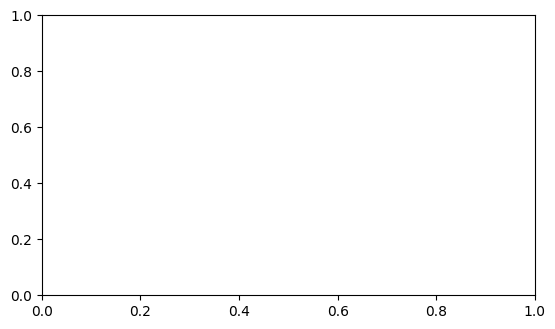

In [19]:







# ============================================================
# 📊 Plot Training Summary
# ============================================================
epochs = np.arange(1, EPOCHS + 1)

plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, history["total_loss"], label="Total Loss")
plt.plot(epochs, history["denoise_loss"], label="Denoise Loss")
plt.plot(epochs, history["seg_loss"], label="Segmentation Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, history["dice"], label="Dice")
plt.plot(epochs, history["iou"], label="IoU (mAP@0.5)")
plt.title("Segmentation Metrics")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, history["ssim"], label="SSIM")
plt.plot(epochs, history["psnr"], label="PSNR")
plt.title("Image Quality Metrics")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()




In [ ]:

# ============================================================
# 🖼️ Visualization (use model call, not model.predict(), to get dict)
# ============================================================
def visualize_predictions(model, noisy_imgs, clean_imgs, masks, num_samples=3):
    preds = model(noisy_imgs[:num_samples], training=False)
    pred_clean = preds["denoise"].numpy()
    pred_mask = preds["segment"].numpy()
    pred_mask_bin = (pred_mask > 0.5).astype("float32")

    fig, axes = plt.subplots(num_samples, 4, figsize=(14, 4*num_samples))
    for i in range(num_samples):
        axes[i, 0].imshow(noisy_imgs[i, :, :, 0], cmap='gray'); axes[i, 0].set_title("Noisy"); axes[i, 0].axis('off')
        axes[i, 1].imshow(pred_clean[i, :, :, 0], cmap='gray'); axes[i, 1].set_title("Denoised"); axes[i, 1].axis('off')
        axes[i, 2].imshow(pred_mask_bin[i, :, :, 0], cmap='gray'); axes[i, 2].set_title("Pred Mask"); axes[i, 2].axis('off')
        axes[i, 3].imshow(masks[i, :, :, 0], cmap='gray'); axes[i, 3].set_title("True Mask"); axes[i, 3].axis('off')
    plt.tight_layout()
    plt.show()

# run visualization on test batch
for noisy, clean, mask in test_dataset.take(1):
    visualize_predictions(multi_model, noisy, clean, mask)



In [ ]:
# ============================================================
# 💾 Save Full Model (self-contained; segmentation head is registered)
# ============================================================
multi_model.save("/content/MSKS_MULTITASK_FINAL.keras")
print("💾 Saved Multi-Task CNNT (denoise + segment) successfully.")